#Zip dataset

In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


#ResNet Model


loading the images of the dataset...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94765736/94765736 [==============================] - 3s 0us/step
compiling model...
training head...
Epoch 1/12
102/102 [==============================] - 593s 6s/step - loss: 0.3134 - accuracy: 0.8887 - val_loss: 0.0722 - val_accuracy: 0.9883
Epoch 2/12
102/102 [==============================] - 540s 5s/step - loss: 0.1237 - accuracy: 0.9657 - val_loss: 0.0405 - val_accuracy: 0.9935
Epoch 3/12
102/102 [==============================] - 575s 6s/step - loss: 0.0823 - accuracy: 0.9769 - val_loss: 0.0331 - val_accuracy: 0.9896
Epoch 4/12
102/102 [==============================] - 571s 6s/step - loss: 0.0704 - accuracy: 0.9783 - val_loss: 0.0275 - val_accuracy: 0.9922
Epoch 5/12
102/102 [==============================] - 570s 6s/step - loss: 0.0606 - accuracy: 0.9832 - val_loss: 0.0264 - val_accuracy: 0.9909
Epoch 6/12
102/102 [==============================] - 581s 6s/step - loss: 0.0535 - accuracy: 0.9868 - val_loss: 0.0247 - val_accuracy: 0.9896
Epoch 7/12
102/102 [=====================

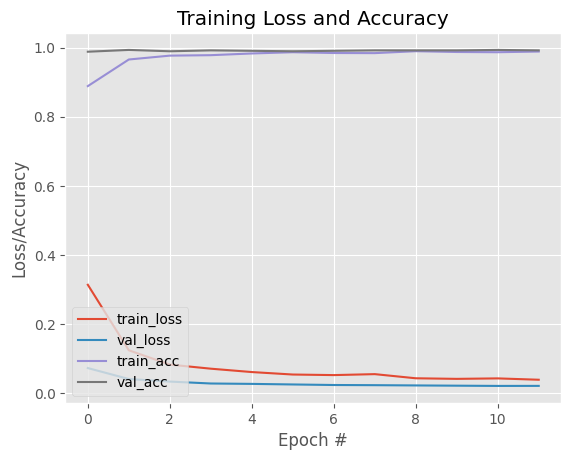

In [ ]:
# import all needed packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers.legacy  import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs and batch size
Learn_Rate = 1e-4
EPOCHS = 12
Batch_Size = 30

Directory = r"/content/dataset"
categories = ["with_mask", "without_mask"]


print("loading the images of the dataset...")

data = []
labels = []

for c in categories:
    path = os.path.join(Directory, c)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(c)

# Preprocess the label so we performed one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# convert the data to numpy array
Data = np.array(data, dtype="float32")
labels = np.array(labels)

# split the images to 80% train and 20 % test
(train_x, test_x, train_y, test_y) = train_test_split(Data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# Perform data augmentation on images to generate new images by ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.20,
	width_shift_range=0.4,
	height_shift_range=0.4,
	shear_range=0.18,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# build the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
# to avoid the overfitting
headModel = Dropout(0.5)(headModel)
# softmax deal with binary represntation 
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

#freeze all layers in the base model because we replace the standard convolutional neural networks
for layer in baseModel.layers:
	layer.trainable = False


# compile our model
print("compiling model...")
lr_schedule = ExponentialDecay(
    initial_learning_rate=Learn_Rate, decay_steps=10000,
    decay_rate=Learn_Rate / EPOCHS)
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# training the head
print("training head...")
train_head = model.fit(
	aug.flow(train_x, train_y, batch_size=Batch_Size),
	steps_per_epoch=len(train_y) // Batch_Size,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // Batch_Size,
	epochs=EPOCHS)

# Evaluate our model
print("evaluating the model...")
predIdxs = model.predict(test_x, batch_size=Batch_Size)


# find the index of the label with maximum predicted probability for every image
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# save the model
print("saving mask detector model...")
model.save("mask_detection.model", save_format="h5")
# plot the training loss and accuracy
No_Of_Epochs = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("loss_plot.png")

#InceptionV3 Model


loading the images of the dataset...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87910968/87910968 [==============================] - 3s 0us/step
compiling model...
training head...
Epoch 1/12
102/102 [==============================] - 567s 6s/step - loss: 0.5192 - accuracy: 0.7737 - val_loss: 0.2284 - val_accuracy: 0.9570
Epoch 2/12
102/102 [==============================] - 554s 5s/step - loss: 0.3507 - accuracy: 0.8633 - val_loss: 0.1548 - val_accuracy: 0.9648
Epoch 3/12
102/102 [==============================] - 551s 5s/step - loss: 0.2913 - accuracy: 0.8956 - val_loss: 0.1266 - val_accuracy: 0.9674
Epoch 4/12
102/102 [==============================] - 556s 5s/step - loss: 0.2732 - accuracy: 0.9018 - val_loss: 0.1096 - val_accuracy: 0.9739
Epoch 5/12
102/102 [==============================] - 557s 5s/step - loss: 0.2584 - accuracy: 0.8995 - val_loss: 0.1014 - val_accuracy: 0.9778
Epoch 6/12
102/102 [==============================] - 557s 5s/step - loss: 0.2401 - accuracy: 0.9117 - val_loss: 0.0951 - val_accuracy: 0.9791
Epoch 7/12
102/102 [=====================

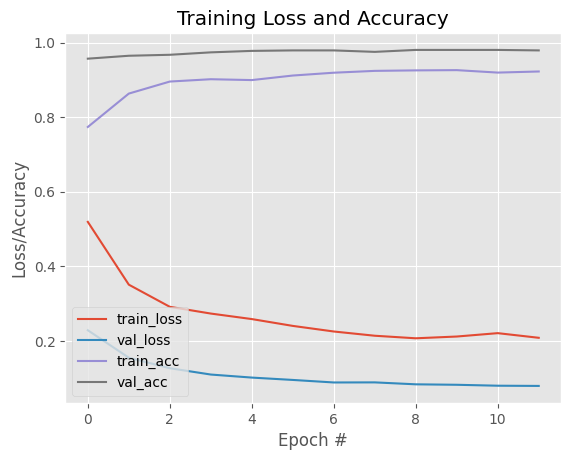

In [ ]:
# import all needed packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers.legacy  import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs and batch size
Learn_Rate = 1e-4
EPOCHS = 12
Batch_Size = 30

Directory = r"/content/dataset"
categories = ["with_mask", "without_mask"]


print("loading the images of the dataset...")

data = []
labels = []

for c in categories:
    path = os.path.join(Directory, c)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(c)

# Preprocess the label so we performed one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# convert the data to numpy array
Data = np.array(data, dtype="float32")
labels = np.array(labels)

# split the images to 80% train and 20 % test
(train_x, test_x, train_y, test_y) = train_test_split(Data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# Perform data augmentation on images to generate new images by ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.20,
	width_shift_range=0.4,
	height_shift_range=0.4,
	shear_range=0.18,
	horizontal_flip=True,
	fill_mode="nearest")

baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# build the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
# to avoid the overfitting
headModel = Dropout(0.5)(headModel)
# softmax deal with binary represntation 
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

#freeze all layers in the base model because we replace the standard convolutional neural networks
for layer in baseModel.layers:
	layer.trainable = False


# compile our model
print("compiling model...")
lr_schedule = ExponentialDecay(
    initial_learning_rate=Learn_Rate, decay_steps=10000,
    decay_rate=Learn_Rate / EPOCHS)
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# training the head
print("training head...")
train_head = model.fit(
	aug.flow(train_x, train_y, batch_size=Batch_Size),
	steps_per_epoch=len(train_y) // Batch_Size,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // Batch_Size,
	epochs=EPOCHS)

# Evaluate our model
print("evaluating the model...")
predIdxs = model.predict(test_x, batch_size=Batch_Size)


# find the index of the label with maximum predicted probability for every image
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# save the model
print("saving mask detector model...")
model.save("mask_detection.model", save_format="h5")
# plot the training loss and accuracy
No_Of_Epochs = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("loss_plot.png")

#MobileNetV2 Model


loading the images of the dataset...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


compiling model...
training head...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/12
102/102 [==============================] - 151s 1s/step - loss: 0.4782 - accuracy: 0.8099 - val_loss: 0.1885 - val_accuracy: 0.9648
Epoch 2/12
102/102 [==============================] - 148s 1s/step - loss: 0.2228 - accuracy: 0.9348 - val_loss: 0.1025 - val_accuracy: 0.9791
Epoch 3/12
102/102 [==============================] - 155s 2s/step - loss: 0.1557 - accuracy: 0.9539 - val_loss: 0.0791 - val_accuracy: 0.9831
Epoch 4/12
102/102 [==============================] - 152s 1s/step - loss: 0.1200 - accuracy: 0.9644 - val_loss: 0.0679 - val_accuracy: 0.9791
Epoch 5/12
102/102 [==============================] - 154s 2s/step - loss: 0.1081 - accuracy: 0.9667 - val_loss: 0.0624 - val_accuracy: 0.9791
Epoch 6/12
102/102 [==============================] - 152s 1s/step - loss: 0.1075 - accuracy: 0.9644 - val_loss: 0.0564 - val_accuracy: 0.9791
Epoch 7/12
102/102 [==============================] - 152s 1s/step - loss: 0.0926 - accuracy: 0.9700 - val_loss: 0.0542 - val_accuracy: 0.9791

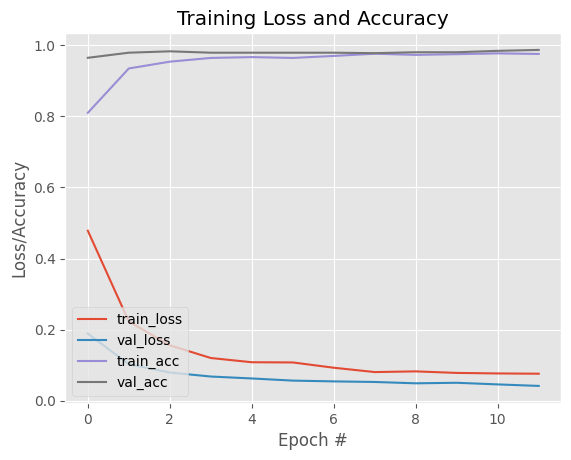

In [ ]:
# import all needed packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers.legacy  import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs and batch size
Learn_Rate = 1e-4
EPOCHS = 12
Batch_Size = 30

Directory = r"/content/dataset"
categories = ["with_mask", "without_mask"]


print("loading the images of the dataset...")

data = []
labels = []

for c in categories:
    path = os.path.join(Directory, c)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(c)

# Preprocess the label so we performed one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# convert the data to numpy array
Data = np.array(data, dtype="float32")
labels = np.array(labels)

# split the images to 80% train and 20 % test
(train_x, test_x, train_y, test_y) = train_test_split(Data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# Perform data augmentation on images to generate new images by ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.20,
	width_shift_range=0.4,
	height_shift_range=0.4,
	shear_range=0.18,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network and make sure the head FC layer sets are left off by setting include_top by false
# imagenet : pretrained model for images and input shape 224*224
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# build the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
# to avoid the overfitting
headModel = Dropout(0.5)(headModel)
# softmax deal with binary represntation 
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

#freeze all layers in the base model because we replace the standard convolutional neural networks
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("compiling model...")

opt = Adam(lr=Learn_Rate, decay=Learn_Rate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# training the head
print("training head...")
train_head = model.fit(
	aug.flow(train_x, train_y, batch_size=Batch_Size),
	steps_per_epoch=len(train_y) // Batch_Size,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // Batch_Size,
	epochs=EPOCHS)

# Evaluate our model
print("evaluating the model...")
predIdxs = model.predict(test_x, batch_size=Batch_Size)


# find the index of the label with maximum predicted probability for every image
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# save the model
print("saving mask detector model...")
model.save("mask_detection.model", save_format="h5")
# plot the training loss and accuracy
No_Of_Epochs = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, No_Of_Epochs), train_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("loss_plot.png")